# Pipeline freq-time analyses: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Beatrice PDK
#### This pipeline uses MNE Python to explore spectral content of the data on the frequency and time-frequency domains working from Epochs: 
####                                https://github.com/hoechenberger/pybrain_mne/blob/main/07-time_frequency.ipynb


In [1]:


import pathlib
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

import mne
import mne_bids
from mne import viz
import numpy as np

mne.set_log_level('warning')



#### Select which file you want to import by specifying ID, session, and task

In [2]:
ID = "001"
session = "01"
task = "pre"

#### Import the Epoch file

In [3]:
path_epochs = "./eeg_output_pre_only/coma_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_epoch_eeg.fif".format(ID, session, ID, session, task)
path_epochs


'./eeg_output_pre_only/coma_tacs/sub-001/ses-01/eeg/sub-001_ses-01_task-pre_epoch_eeg.fif'

#### Set parameters

In [4]:
epochs =  mne.read_epochs(path_epochs)


/tmp/ipykernel_13258/255478258.py:1: RuntimeWarning: This filename (./eeg_output_pre_only/coma_tacs/sub-001/ses-01/eeg/sub-001_ses-01_task-pre_epoch_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs =  mne.read_epochs(path_epochs)


In [5]:
epochs


Number of events,12
Events,1: 12
Time range,0.000 – 9.996 sec
Baseline,off


#### Frequency analysis 

We start by exploring the frequence content of our epochs.

Let's first check out all channel types by averaging across epochs.



REMARK:

    Select a frequency range in the plot to inspect topographies
    The "bandwidth" parameter controls the spectral resolution of the multitaper. You can increase the resolution by chosing a narrower bandwidth at the cost of longer computation time.



In [6]:
%matplotlib qt
epochs.plot_psd(fmax=70)
plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_brainonly.png'.format(ID,session,task,ID,session,task))

In order to choose specific channels

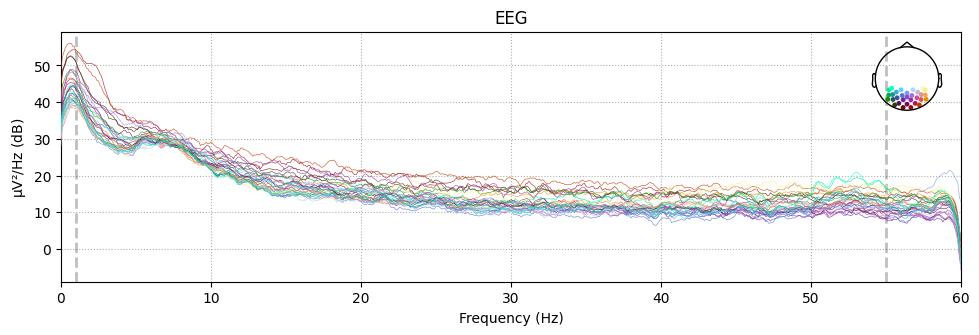

In [7]:
%matplotlib qt
epochs.plot_psd( fmax = 60, picks= ['E92','E97','E78','E62','E85','E77','E91','E96','E84','E75','E90','E95','E52','E51','E61','E60','E66','E65','E64','E67','E59','E58','E69','E72','E75', 'E70','E71','E76','E83','E69','E89','E82','E74'])#parieto-occipital

Now let's take a look at the spatial distributions of the PSD.

In [8]:
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-45 Hz)': (30, 45)}

In [10]:
epochs.plot_psd_topomap(ch_type='eeg',bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-45 Hz)': (30, 45)}, normalize=False)
plt.savefig('./out_figures/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_topo_epochs.png'.format(ID,session,task,ID,session,task))


ValueError: too many values to unpack (expected 3)

It can be interesting to consider the relative power, defined as the power in a given band divided by the total power. To explore this option, have a look at the "normalize" keyword.



In [ ]:
epochs.plot_psd_topomap(ch_type='eeg', normalize=True)
plt.savefig('./out_figures/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_topo_relativepower.png'.format(ID,session,task,ID,session,task))

In [ ]:
# Define frequency bands of interest
bands = Bands({'theta': [3, 7],
               'alpha': [7, 14],
               'beta': [15, 30]})

In [ ]:
# Extract alpha peaks
alphas = get_band_peak_fg(fg, bands.alpha)

# Extract the power values from the detected peaks
alpha_pw = alphas[:, 1]

In [ ]:
# Plot the topography of alpha power
plot_topomap(alpha_pw, raw.info, cmap=cm.viridis, contours=0);

And there we have it, our first topography of parameterized spectra, showing alpha power!

The topography makes sense, as we can see a centro-posterior distribution.

Now we can extend this to plot the power of each of our other defined frequency bands.




In [ ]:
# Plot the topographies across different frequency bands
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ind, (label, band_def) in enumerate(bands):

    # Get the power values across channels for the current band
    band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])

    # Create a topomap for the current oscillation band
    mne.viz.plot_topomap(band_power, raw.info, cmap=cm.viridis, contours=0,
                         axes=axes[ind], show=False);

    # Set the plot title
    axes[ind].set_title(label + ' power', {'fontsize' : 20})

Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs. We'll look at power and inter-trial coherence (ITC).

To this we'll use the function mne.time_frequency.tfr_morlet but you can also use mne.time_frequency.tfr_multitaper or mne.time_frequency.tfr_stockwell.

In [ ]:
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([2, 30]), num=20)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                                           return_itc=True, decim=3, n_jobs=1)


In [ ]:
power.crop(-0.1, 0.7)  # crop to remove edge artifacts

In [ ]:

itc.crop(-0.1, 0.7)  # crop to remove edge artifacts

Inspect power

The generated figures are interactive. In the topo you can click on an image to visualize the data for one sensor. You can also select a portion in the time-frequency plane to obtain a topomap for a certain time-frequency region.

In [ ]:
baseline_mode = 'logratio'
baseline = (None, 0)


Plot power topomap

In [ ]:
(power.copy()
 .pick_types(eeg=True, meg=False)
 .plot_topo())


Plot power of an individual channel

In [ ]:
power.plot(picks='E75', baseline=baseline, mode=baseline_mode)

Plot topomaps for specified frequency ranges

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=0, fmax=3.99,
                   baseline=baseline, mode=baseline_mode, axes=axis[0],
                   title='Delta', show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=4, fmax=7,
                   baseline=baseline, mode=baseline_mode, axes=axis[0],
                   title='Theta', show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=baseline, mode=baseline_mode, axes=axis[1],
                   title='Alpha', show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=13, fmax=30,
                   baseline=baseline, mode=baseline_mode, axes=axis[2],
                   title='Beta', show=False, contours=1)
#power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=31, fmax=45,
                   #baseline=baseline, mode=baseline_mode, axes=axis[0],
                   #title='Gamma', show=False, contours=1)
mne.viz.tight_layout()
plt.show()

plt.savefig('./out_figures/doc-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_topo_specific_freq.png'.format(ID,session,task,ID,session,task))


Joint Plot

You can also create a joint plot showing both the aggregated TFR across channels and topomaps at specific times and frequencies to obtain a quick overview regarding oscillatory effects across time and space.


In [ ]:
power.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.05, 20), (0.1, 11.)])
plt.show()

Inspect ITC



In [ ]:
itc.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=0.5, cmap='Reds')

Baseline correction can be applied to power or done in plots. To illustrate the baseline correction in plots, the next line is commented power.apply_baseline(baseline=(-0.5, 0), mode='logratio')

In [ ]:
power.apply_baseline(baseline=(-0.5, 0), mode='logratio')

In [ ]:
power.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.05, 2.), (0.1, 15)])
plt.show()

In [ ]:
itc.plot_joint(baseline=baseline, mode='mean', tmin=None, tmax=None,
                 timefreqs=[(0.05, 2.), (0.1, 11.)])
plt.show()
